<a href="https://colab.research.google.com/github/zyf2021/Cinnamon-Plant-Stem-and-Branch-Disease-Dataset/blob/main/%D0%9E%D0%B1%D1%83%D1%87%D0%B5%D0%BD%D0%B8%D0%B5_%D0%BD%D0%B0_%D1%80%D0%B0%D1%81%D0%BF%D0%BE%D0%B7%D0%BD%D0%B0%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D1%82%D0%B8%D0%BF%D0%BE%D0%B2_%D0%BA%D0%BE%D1%80%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d madhavipethangoda/cinnamon-plant-stem-and-branch-disease-dataset

100% 663M/664M [00:31<00:00, 20.5MB/s]
100% 664M/664M [00:31<00:00, 21.8MB/s]


In [7]:
! unzip /content/cinnamon-plant-stem-and-branch-disease-dataset.zip

Archive:  /content/cinnamon-plant-stem-and-branch-disease-dataset.zip
  inflating: Diseases/RoughBark/IMG_1563.JPG  
  inflating: Diseases/RoughBark/IMG_1564.JPG  
  inflating: Diseases/RoughBark/IMG_1668.JPG  
  inflating: Diseases/RoughBark/IMG_1887.JPG  
  inflating: Diseases/RoughBark/IMG_1944.JPG  
  inflating: Diseases/RoughBark/IMG_1964.JPG  
  inflating: Diseases/RoughBark/IMG_1965.JPG  
  inflating: Diseases/RoughBark/IMG_2010.JPG  
  inflating: Diseases/RoughBark/IMG_2044.JPG  
  inflating: Diseases/RoughBark/IMG_2058.JPG  
  inflating: Diseases/RoughBark/IMG_2098.JPG  
  inflating: Diseases/RoughBark/IMG_4780.JPG  
  inflating: Diseases/RoughBark/IMG_4782.JPG  
  inflating: Diseases/RoughBark/IMG_4783.JPG  
  inflating: Diseases/RoughBark/IMG_4784.JPG  
  inflating: Diseases/RoughBark/IMG_4785.JPG  
  inflating: Diseases/RoughBark/IMG_4786.JPG  
  inflating: Diseases/RoughBark/IMG_4787.JPG  
  inflating: Diseases/RoughBark/IMG_4788.JPG  
  inflating: Diseases/RoughBark/IMG_4

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import splitfolders
splitfolders.ratio('/content/Diseases', output="./", seed=1337, ratio=(.7, 0.2,0.1)) 

Copying files: 326 files [00:02, 154.68 files/s]


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES=True

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [11]:
def check_image(path):
    try:
        im = Image.open(path)
        return True
    except:
        return False

In [12]:
img_transforms = transforms.Compose([
    transforms.Resize((64,64)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225] )
    ])

In [13]:
train_data_path = '/content/train'
train_data = torchvision.datasets.ImageFolder(root=train_data_path,transform=img_transforms, is_valid_file=check_image)

In [14]:
val_data_path = '/content/val'
val_data = torchvision.datasets.ImageFolder(root=val_data_path,transform=img_transforms, is_valid_file=check_image)

In [15]:
test_data_path = '/content/test'
test_data = torchvision.datasets.ImageFolder(root=test_data_path,transform=img_transforms, is_valid_file=check_image) 

In [16]:
batch_size=64

In [17]:
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
val_data_loader  = torch.utils.data.DataLoader(val_data, batch_size=batch_size) 
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size=batch_size) 

In [18]:
class SimpleNet(nn.Module):

    def __init__(self):
        super(SimpleNet, self).__init__()
        
        self.fc1 = nn.Linear(12288, 84)
        self.fc2 = nn.Linear(84, 50)
        self.fc3 = nn.Linear(50,2)
    
    def forward(self, x):
        x = x.view(-1, 12288)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [19]:
simplenet = SimpleNet()

In [20]:
optimizer = optim.Adam(simplenet.parameters(), lr=0.001)

In [21]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

simplenet.to(device)

SimpleNet(
  (fc1): Linear(in_features=12288, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

In [26]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=5, device="cpu"):
    epoch_data= []
    training_loss_data = []
    valid_loss_data = []
    accuracy_data = []
    for epoch in range(1, epochs+1):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))
        
        epoch_data.append(epoch)
        training_loss_data.append(training_loss)
        valid_loss_data.append(valid_loss)
        accuracy_data.append(num_correct / num_examples)
        
        fig, ax = plt.subplots(figsize=(8, 6))
        ax.set_title('Графики зависимостей', fontsize=16)
        ax.set_xlabel('Epoch', fontsize=14)
        ax.set_ylabel('Training Loss, Validation Loss, accuracy', fontsize=14)
        ax.grid(which='major', linewidth=1.2)
        ax.grid(which='minor', linestyle='--', color='gray', linewidth=0.5)
        
        ax.scatter(epoch_data, accuracy_data, c='red', label='accuracy')
        ax.plot(epoch_data, training_loss_data, c='yellow', label='Training Loss')
        ax.plot(epoch_data, valid_loss_data, c='green', label='Validation Loss')
        
        ax.legend()

        plt.show()
    ##fig, ax = plt.subplots(figsize=(8, 6))
    ##ax.set_title('Графики зависимостей', fontsize=16)
    ##ax.set_xlabel('Epoch', fontsize=14)
    ##ax.set_ylabel('Training Loss, Validation Loss, accuracy', fontsize=14)
    ##ax.grid(which='major', linewidth=1.2)
    ##ax.grid(which='minor', linestyle='--', color='gray', linewidth=0.5)
    ##ax.scatter(epoch_data, accuracy_data, c='red', label='accuracy')
    ##ax.plot(epoch_data, training_loss_data, c='yellow', label='Training Loss')
    ##ax.plot(epoch_data, valid_loss_data, c='green', label='Validation Loss')
    ##ax.legend()

    ##ax.xaxis.set_minor_locator(AutoMinorLocator())
    ##ax.yaxis.set_minor_locator(AutoMinorLocator())
    ##ax.tick_params(which='major', length=10, width=2)
    ##ax.tick_params(which='minor', length=5, width=1)


    



Epoch: 1, Training Loss: 0.48, Validation Loss: 0.57, accuracy = 0.72


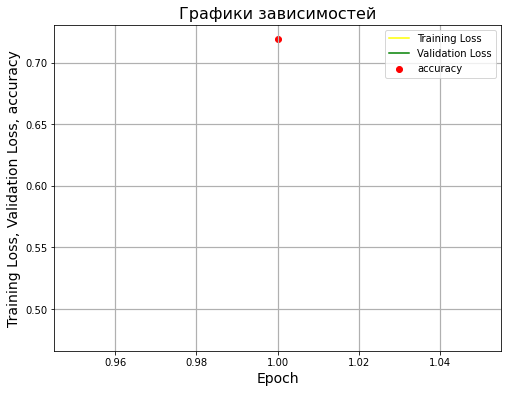

Epoch: 2, Training Loss: 0.35, Validation Loss: 0.49, accuracy = 0.83


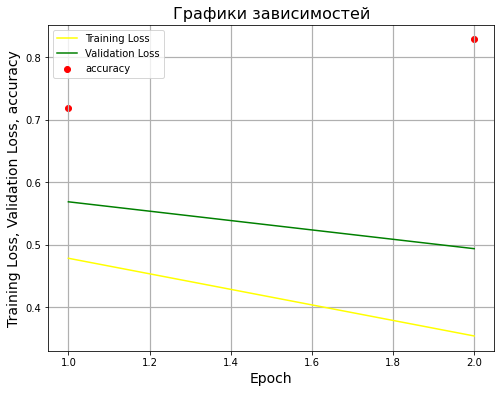

Epoch: 3, Training Loss: 0.22, Validation Loss: 0.48, accuracy = 0.88


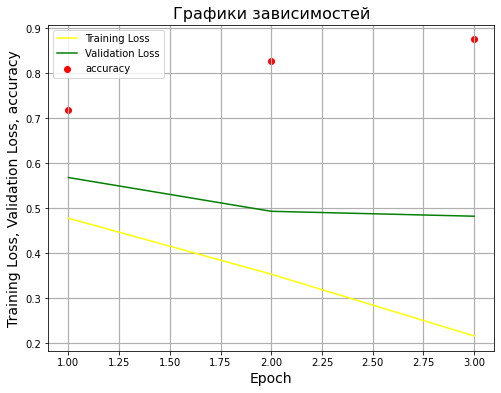

Epoch: 4, Training Loss: 0.14, Validation Loss: 0.49, accuracy = 0.84


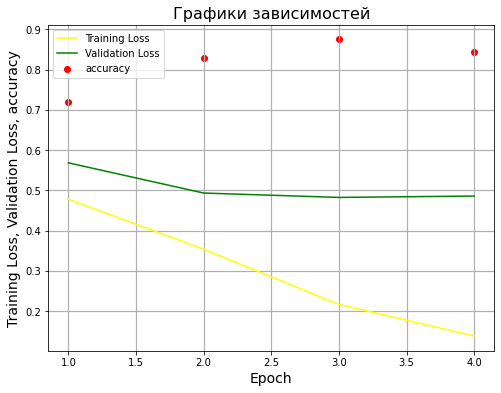

Epoch: 5, Training Loss: 0.10, Validation Loss: 0.49, accuracy = 0.83


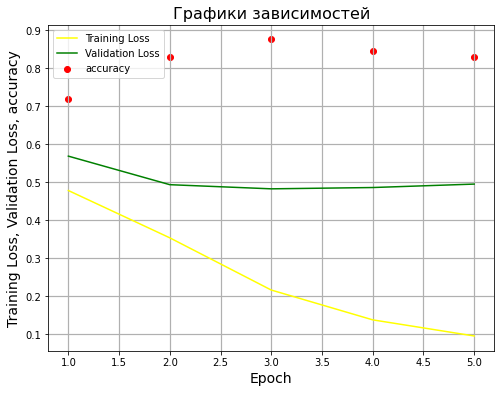

Epoch: 6, Training Loss: 0.07, Validation Loss: 0.50, accuracy = 0.83


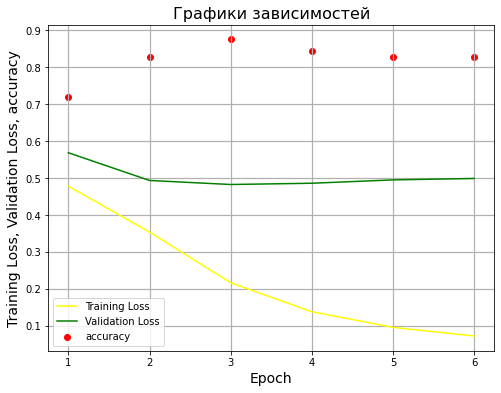

Epoch: 7, Training Loss: 0.05, Validation Loss: 0.51, accuracy = 0.83


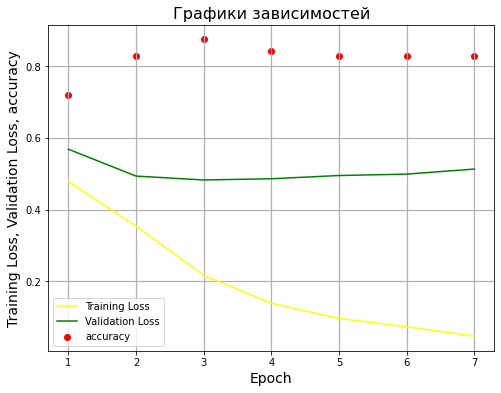

Epoch: 8, Training Loss: 0.03, Validation Loss: 0.53, accuracy = 0.83


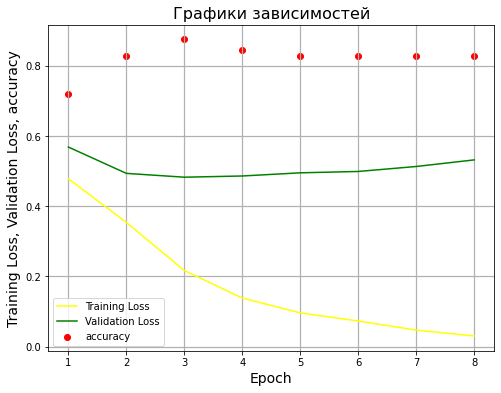

Epoch: 9, Training Loss: 0.02, Validation Loss: 0.55, accuracy = 0.81


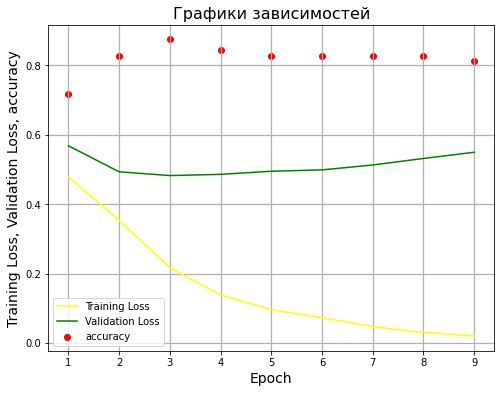

Epoch: 10, Training Loss: 0.01, Validation Loss: 0.56, accuracy = 0.81


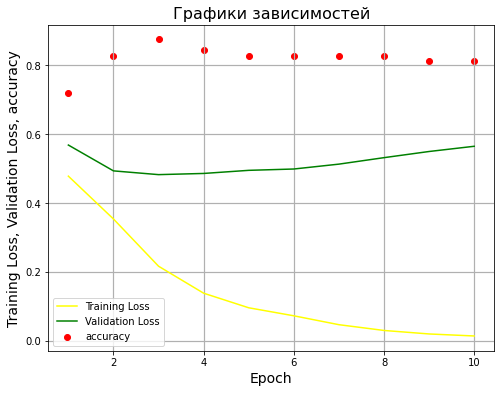

Epoch: 11, Training Loss: 0.01, Validation Loss: 0.58, accuracy = 0.83


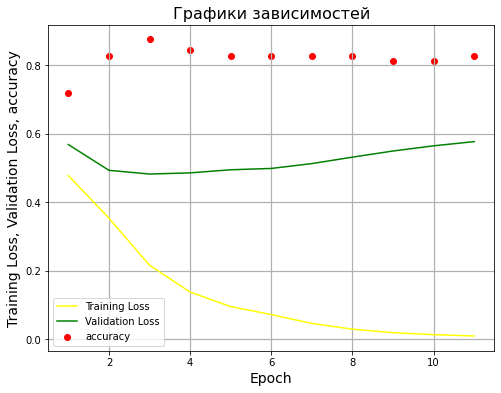

Epoch: 12, Training Loss: 0.01, Validation Loss: 0.59, accuracy = 0.83


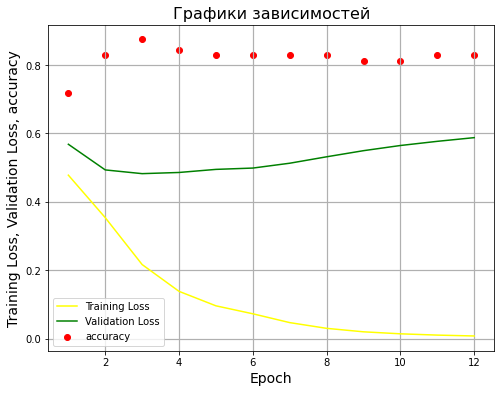

Epoch: 13, Training Loss: 0.01, Validation Loss: 0.60, accuracy = 0.83


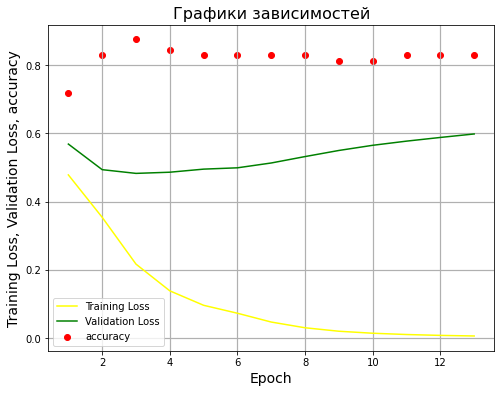

Epoch: 14, Training Loss: 0.00, Validation Loss: 0.61, accuracy = 0.83


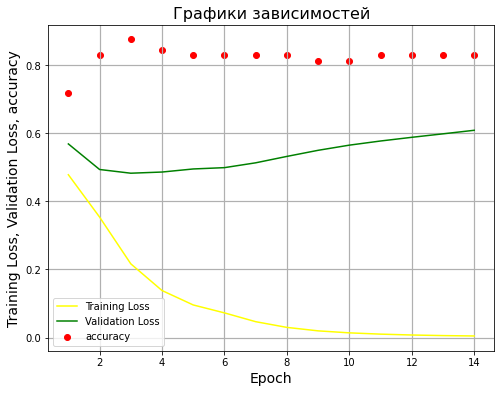

Epoch: 15, Training Loss: 0.00, Validation Loss: 0.62, accuracy = 0.83


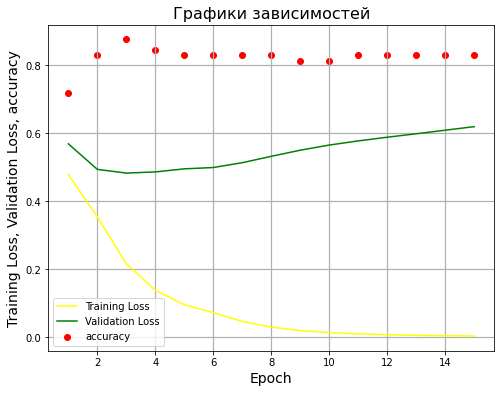

Epoch: 16, Training Loss: 0.00, Validation Loss: 0.63, accuracy = 0.83


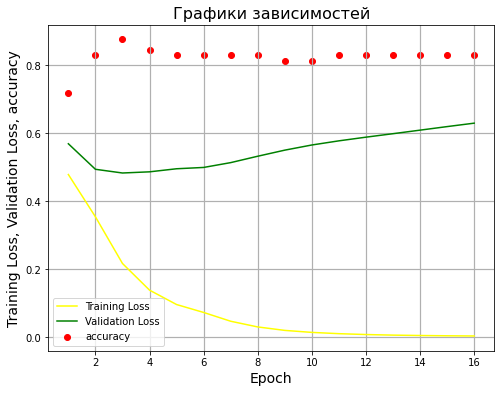

Epoch: 17, Training Loss: 0.00, Validation Loss: 0.64, accuracy = 0.83


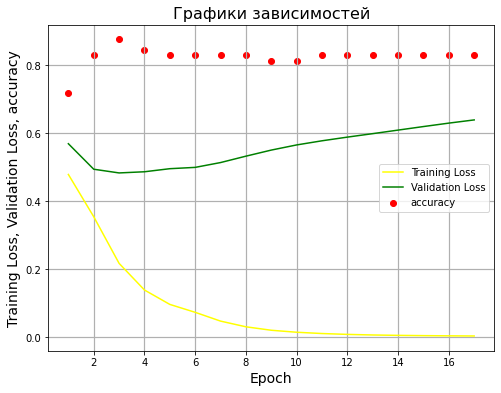

Epoch: 18, Training Loss: 0.00, Validation Loss: 0.65, accuracy = 0.83


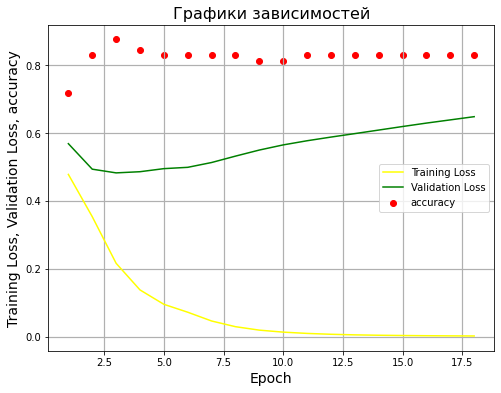

Epoch: 19, Training Loss: 0.00, Validation Loss: 0.66, accuracy = 0.83


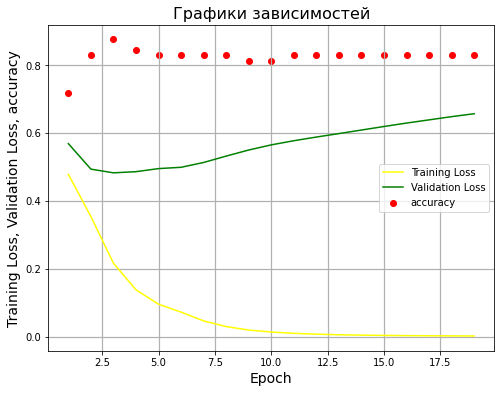

Epoch: 20, Training Loss: 0.00, Validation Loss: 0.66, accuracy = 0.83


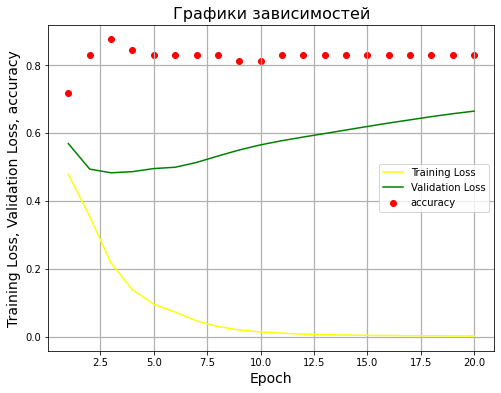

In [27]:
train(simplenet, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=20, device=device)

In [28]:
labels = ['RoughBark','StripeCanker']

img = Image.open("/content/test/StripeCanker/IMG_1677.JPG") 
img = img_transforms(img).to(device)
img = torch.unsqueeze(img, 0)

simplenet.eval()
prediction = F.softmax(simplenet(img), dim=1)
prediction = prediction.argmax()
print(labels[prediction]) 

StripeCanker


In [33]:
torch.save(simplenet, "./simplenet") 
simplenet = torch.load("/tmp/simplenet") 

In [32]:
torch.save(simplenet.state_dict(), "./simplenet")    
simplenet = SimpleNet()
simplenet_state_dict = torch.load("./simplenet")
simplenet.load_state_dict(simplenet_state_dict)   

<All keys matched successfully>